In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN.ipynb"
#!python setup.py develop 
# !pip install wandb
# !pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob, math, os, shutil, tempfile, time, monai, torch, random

import wandb as wb
from enum import Enum
import pandas as pd
import numpy as np
import nibabel as nib
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from monai.networks.utils import eval_mode
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    ImageDataset,
    Dataset,
    decollate_batch,
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.transforms import (
    AddChannel,
    AsChannelFirst,
    Compose,
    SplitDim,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    Lambda,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
from monai.utils import set_determinism

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_config()
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

MONAI version: 0.8.1+331.g6a301d51.dirty
Numpy version: 1.20.1
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 6a301d51fbbb1803b7349a85c9bfa398f19ee0f9
MONAI __file__: /home/alexanderalbizu/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 9.1.1
Tensorboard version: 1.15.0+nv
gdown version: 4.4.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 1.26.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


anat images/labels:  (40341,) (40341, 1)
func images/labels:  (3254400,) (3254400, 1)
/blue/camctrp/working/gullettj/ACT/organized_data/sub-117219/ses-01/anat/2D/T1_n111.png
anat Shape: (181, 217)
/blue/camctrp/working/gullettj/ACT/organized_data/sub-107802/ses-01/func/2D/BOLD_n60_v116.png
func Shape: (91, 109)


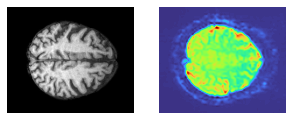

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/'
dataDir = '/blue/camctrp/working/gullettj/ACT/organized_data/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();
batch_size=128
anat_size = (200,200)
func_size = (100,100)
mri_types = ['anat','func']
grad_clip = 2
step_size = 1
gamma = 7e-1
seed = 42
samples_to_exclude = np.array([103744,106986,300142,101644,105903,106078,106817,101395,105554,204085])
exclude = np.equal(np.isin(sdata[:,0],samples_to_exclude),0);
num_cores = int(os.environ["SLURM_CPUS_PER_TASK"]);
anat_dims = np.array([181,217,181])
func_dims = np.array([91,108,91,120])
lr = 1e-4
wd = 0

# start a typical PyTorch training
val_interval = 1
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
max_epochs = 50
num_cores = int(os.environ["SLURM_CPUS_PER_TASK"]);

subs = sdata[exclude,0]; 
l = np.array([sdata[:,1]]);
l = l[:,exclude]; 

class Diagnosis(Enum):
    NonResponder = 0
    Responder = 1
    
anat = []; func = []; 
anat_lab = []; func_lab = []; 
for s in range(subs.shape[0]):
    for n in range(anat_dims[2]):
        if n > 30 and n < 150:
            anat.append(os.path.join(dataDir,'sub-'+str(subs[s]),'ses-01','anat','2D','T1_n'+str(n+1)+'.png'));
            anat_lab.append(l[0,s]);
        if n < func_dims[2] and n > 10:
            for v in range (func_dims[3]):
                func.append(os.path.join(dataDir,'sub-'+str(subs[s]),'ses-01','func','2D','BOLD_n'+str(n+1)+'_v'+str(v+1)+'.png'));
                func_lab.append(l[0,s]);
anat = np.asarray(anat); anat_lab = np.asarray([anat_lab]).T; func = np.asarray(func); func_lab = np.asarray([func_lab]).T;
print('anat images/labels: ',anat.shape,anat_lab.shape)
print('func images/labels: ',func.shape,func_lab.shape)
# Plot Labels
plt.rcParams['figure.figsize'] = [30, 30]; plt.imshow(anat_lab.T); plt.axis('off'); plt.title('Class Labels');

# Plot OG Images
fig, axes = plt.subplots(*[1,2], figsize=(5, 5), facecolor="white")

# anat
imid = random.randrange(anat.shape[0])
print(anat[imid])
img = plt.imread(anat[imid]); # Load Each Electrode
axes[0].imshow(img, cmap="gray", origin="lower"); axes[0].axis('off');
print('anat Shape:',img.shape)

# func
imid = random.randrange(func.shape[0])
print(func[imid])
img = plt.imread(func[imid]); # Load Each Electrode
axes[1].imshow(img, cmap="turbo", origin="lower"); axes[1].axis('off');
print('func Shape:',img.shape)

# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
    
# seed_everything(seed)    

In [4]:
for m in mri_types:

    if m == "anat":
        nontest_list, test_list = train_test_split(anat, 
                                                  test_size=0.10,
                                                  stratify=anat_lab,
                                                  random_state=seed)
        nontest_label, test_label = train_test_split(anat_lab, 
                                                  test_size=0.10,
                                                  stratify=anat_lab,
                                                  random_state=seed) ###################### WIP REMOVE ALL IMAGES FROM TEST SET
    elif m == "func":
        nontest_list, test_list = train_test_split(func, 
                                                  test_size=0.10,
                                                  stratify=func_lab,
                                                  random_state=seed)
        nontest_label, test_label = train_test_split(func_lab, 
                                                  test_size=0.10,
                                                  stratify=func_lab,
                                                  random_state=seed)
    train_list, valid_list = train_test_split(nontest_list, 
                                              test_size=0.10,
                                              stratify=nontest_label,
                                              random_state=seed)
    train_label, valid_label = train_test_split(nontest_label, 
                                              test_size=0.10,
                                              stratify=nontest_label,
                                              random_state=seed)
    # Oversampling the Unbalnaced Class
    train_list = np.array(np.hstack([[train_list.T],[train_list.T]]))[0,:];
    train_label = np.array([np.int64(np.hstack([train_label[:,0],train_label[:,0]]))]).T;

    print('train case split: ',sum(train_label)[0],':',len(train_label)-sum(train_label)[0])
    print('valid case split: ',sum(valid_label)[0],':',len(valid_label)-sum(valid_label)[0])
    print('test case split: ',sum(test_label)[0],':',len(test_label)-sum(test_label)[0],'\n')
    del nontest_list, nontest_label; # Save RAM

    # Represent labels in one-hot format for binary classifier training,
    # BCEWithLogitsLoss requires target to have same shape as input
    labels = nn.functional.one_hot(torch.as_tensor(anat_lab.T)).long();
    train_lab = nn.functional.one_hot(torch.as_tensor(train_label.T)).long(); 
    valid_lab = nn.functional.one_hot(torch.as_tensor(valid_label.T)).long();
    test_lab = nn.functional.one_hot(torch.as_tensor(test_label.T)).long();

    # Define transforms
    train_transforms = Compose([
        AddChannel(),
        Resize(anat_size),
    #     RandBiasField(),
        RandGaussianNoise(prob=0.5), 
        ScaleIntensity(minv=0.0, maxv=1.0),
        EnsureType(data_type='tensor')]);

    val_transforms = Compose([
        AddChannel(),
        Resize(anat_size),
        ScaleIntensity(minv=0.0, maxv=1.0),
        EnsureType(data_type='tensor')]);

    # Define nifti dataset, data loader
#     check_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
#     check_loader = DataLoader(check_ds, batch_size=1, num_workers=num_cores, pin_memory=pin_memory); 

#     im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
#     plt.imshow(im[0,:,:,:].T, cmap="gray", origin="lower"); plt.axis('off'); del check_ds, check_loader, im, label;

    # create a training data loader
    train_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=pin_memory);

    # create a validation data loader
    val_ds = ImageDataset(image_files=valid_list, labels=valid_lab[0,:,:], transform=val_transforms);
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)

    def save_model(n_epoch, save_path, run_id):
            lastmodel = f"{save_path}-{run_id}.pth"
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_valid_score": best_valid_score,
                    "n_epoch": n_epoch,
                },
                lastmodel,
            )

    # Create DenseNet121, CrossEntropyLoss and Adam optimizer
    model = monai.networks.nets.DenseNet264(spatial_dims=2, in_channels=1, out_channels=2).to(device)

    # Loss Function
    loss_fx = torch.nn.BCEWithLogitsLoss() 

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    wb.init(project="ACT-CNN-2D",
               config={
                   "batch_size": batch_size,
                   "n_channels": 3,
                   "n_epoch": max_epochs,
                   "anat_size": anat_size,
                   "func_size": func_size,
                   "learning_rate": lr,
                   "mri_type": m,
                   "network": "DenseNet264",
                   "weight_decay": wd,
                   "dataset": "SB",
               })
    run_id = wb.run.name;
    wb.watch(model, log='all')

    scaler = torch.cuda.amp.GradScaler()
    best_valid_score = 99999; # Initialize Loss
    lastmodel = None
    for epoch in range(max_epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for batch_data in train_loader:
            inputs, label = batch_data[0].to(device), batch_data[1].to(device);

            # Evaluate Model
            output = model(inputs);
            loss = loss_fx(output, label.float())

            # Update Gradient
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                # Evaluate Model
                output = model(inputs); epoch_prob = torch.nn.functional.softmax(output,dim=1)
                loss = loss_fx(output, label.float())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Accuracy
            acc = (epoch_prob.argmax(dim=1) == label.argmax(dim=1)).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_acc_values.append(acc)

            # Loss
            epoch_loss += loss / len(train_loader)
            epoch_loss_values.append(epoch_loss)
#             print(f"train loss: {loss.item():.4f}")
            wb.log({'train_loss': loss, 'train_acc': acc})

        if epoch % val_interval == 0: # Validation Interval
            with eval_mode(model):
                epoch_val_accuracy = 0; epoch_val_loss = 0;
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

                    val_output = model(val_images); val_prob = torch.nn.functional.softmax(val_output,dim=1);
                    val_loss = loss_fx(val_output, val_labels.float())

                    val_acc = (val_prob.argmax(dim=1) == val_labels.argmax(dim=1)).float().mean()
                    epoch_val_accuracy += val_acc / len(val_loader)
                    epoch_val_loss += val_loss / len(val_loader)
                    wb.log({'val_loss': val_loss, 'val_acc': val_acc})
            print(
                f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
            )

            #Save Best Model
            if best_valid_score > epoch_val_loss:
                print("model saved")
                save_model(epoch, m, run_id)
                best_valid_score = epoch_val_loss

        else:    
            print(
                f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} \n"
            )

    wb.run.log_code(root=os.path.join(os.getcwd(),"CNN_SMART.ipynb")); wb.finish()

train case split:  12722 : 52628
valid case split:  707 : 2924
test case split:  786 : 3249 



Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)


Epoch : 1 - train_loss : 0.4392 - train_acc: 0.8206 - val_loss : 2.1763 - val_acc: 0.3364

model saved
Epoch : 2 - train_loss : 0.2160 - train_acc: 0.9137 - val_loss : 0.2318 - val_acc: 0.9090

model saved
Epoch : 3 - train_loss : 0.0885 - train_acc: 0.9674 - val_loss : 0.3892 - val_acc: 0.8548

Epoch : 4 - train_loss : 0.0495 - train_acc: 0.9828 - val_loss : 0.1349 - val_acc: 0.9498

model saved
Epoch : 5 - train_loss : 0.0328 - train_acc: 0.9882 - val_loss : 0.4873 - val_acc: 0.8847

Epoch : 6 - train_loss : 0.0312 - train_acc: 0.9890 - val_loss : 0.1136 - val_acc: 0.9597

model saved
Epoch : 7 - train_loss : 0.0226 - train_acc: 0.9921 - val_loss : 0.1518 - val_acc: 0.9543

Epoch : 8 - train_loss : 0.0251 - train_acc: 0.9913 - val_loss : 0.1161 - val_acc: 0.9616

Epoch : 9 - train_loss : 0.0197 - train_acc: 0.9933 - val_loss : 0.9523 - val_acc: 0.7620

Epoch : 10 - train_loss : 0.0202 - train_acc: 0.9931 - val_loss : 0.1002 - val_acc: 0.9699

model saved
Epoch : 11 - train_loss : 0.0

train_acc,▁▅██▇██████▇▇█████▇█████████████████████
train_loss,█▄▂▁▃▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▆▇█▇▇▆█▇▇███▇▇██▇██▇██████▇▇█▇█▇▇█████
val_loss,█▂▂▁▁▂▂▃▁▂▂▁▁▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▃▁▁▁▁▁
train_acc,1.0
train_loss,0.00039
val_acc,1.0
val_loss,0.00095


train case split:  1026432 : 4245696
valid case split:  57024 : 235872
test case split:  63360 : 262080 



FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/alexanderalbizu/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/alexanderalbizu/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/alexanderalbizu/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/alexanderalbizu/MONAI/monai/data/image_dataset.py", line 105, in __getitem__
    img = self.loader(self.image_files[index])
  File "/home/alexanderalbizu/MONAI/monai/transforms/io/array.py", line 213, in __call__
    img = reader.read(filename)
  File "/home/alexanderalbizu/MONAI/monai/data/image_reader.py", line 670, in read
    img = PILImage.open(name, **kwargs_)
  File "/home/alexanderalbizu/.local/lib/python3.8/site-packages/PIL/Image.py", line 3068, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/blue/camctrp/working/gullettj/ACT/organized_data/sub-105687/ses-01/func/2D/BOLD_n43_v82.png'


# Test Model

In [ ]:
%%time
modelfiles = f'T1-lyric-pond-1.pth'; # HARDCODED4

for m in modelfiles
    checkpoint = torch.load(m)

    # create a validation data loader
    test_ds = ImageDataset(image_files=test_list, labels=test_lab[0,:,:], transform=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)
    model.load_state_dict(checkpoint["model_state_dict"])

    with eval_mode(model):
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)
        test_acc = 0
        for test_data in test_loader:
            test_images, test_labels = test_data[0].to(
                device), test_data[1].to(device)

            outputs = model(test_images); probs = torch.nn.functional.softmax(outputs,dim=1);
            test_acc += (probs.argmax(dim=1) == test_labels.argmax(dim=1)).float().mean();
            y_pred = torch.cat([y_pred, probs.argmax(dim=1)], dim=0)
            y = torch.cat([y, test_labels.argmax(dim=1)], dim=0);
        test_acc = test_acc / len(test_loader) ##### WIP AVERAGE PROB

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])

disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Occulusion Sensitivity

In [ ]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAMpp(
    nn_module=model, target_layers="class_layers.relu"
)
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print(
    "original feature shape",
    cam.feature_map_size([1, 3] + list(im_size), device),
)
print("upsampled feature shape", [1, 3] + list(im_size))

occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=4, n_batch=1, stride=4
)

# For occlusion sensitivity, inference must be run many times. Hence, we can use a
# bounding box to limit it to a 2D plane of interest (z=the_slice) where each of
# the arguments are the min and max for each of the dimensions (in this case CHWD).

train_transforms.set_random_state(42)
n_examples = 3
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data[0].to(device).unsqueeze(0), data[1][1]
    y_pred = model(image); prob = torch.nn.functional.softmax(y_pred,dim=1);
    pred_label = prob.argmax(dim=1);
    
    # Only display preMCI
    if np.not_equal(label,1):
        continue

    img = image.detach().cpu().numpy()

    name = "actual: "
    name += "Responder" if np.equal(label,1) else "Non-Responder"
    name += "\npred: "
    name += "Responder" if np.equal(pred_label.cpu().numpy(),1) else "Non-Responder"
    name += f"\nResponder: {prob[0,1]:.3}"
    name += f"\nNon-Responder: {prob[0,0]:.3}"

    # run CAM
    cam_result = cam(x=image, class_idx=None)
    cam_result = cam_result

    # run occlusion
    occ_result, _ = occ_sens(x=image)
    occ_result = occ_result[..., pred_label];

    if isinstance(img, torch.Tensor):
            img = img.cpu().detach()
    ax = axes[0, example]
    im_show = ax.imshow(np.squeeze(img[0][0].T), cmap="jet", origin='lower')
    ax.set_title(name, fontsize=25)
    ax.axis("off")
    
    if isinstance(cam_result, torch.Tensor):
        cam_result = cam_result.cpu().detach()
    ax = axes[1, example]
    im_show = ax.imshow(np.squeeze(img[0][0].T), cmap="gray", origin='lower')
    im_show = ax.imshow(np.squeeze(cam_result[0][0].T), cmap="jet", origin='lower', alpha=0.5)
    ax.set_title("Grad-CAM++", fontsize=25)
    ax.axis("off")
    
    if isinstance(occ_result, torch.Tensor):
            occ_result = occ_result.cpu().detach()
    ax = axes[2, example]
    im_show = ax.imshow(np.squeeze(img[0][0].T), cmap="gray", origin='lower')
    im_show = ax.imshow(np.squeeze(occ_result[0][0].T), cmap="jet", origin='lower', alpha=0.5)
    ax.set_title("Occ. Sens", fontsize=25)
    ax.axis("off")
    
    example += 1
    if example == n_examples:
        break